In [1]:
%config InlineBackend.figure_formats = ['svg']

## Symulacje numeryczne interferencji dla przybliżenia płaskiej wody
#### Patryk Kościelniak
#### Semestr 2025/2026

### Opis problemu
Symulujemy układ, w którym rozważamy dwa źródła fal kulistych. Źródła leżą na wspólnej prostej, prosta ta wyznacza kierunek osi Y. Kierunek osi X jest kierunkiem prostopadłym do osi Y. Celem jest porównanie modelu numerycznego z wynikiem teoretycznym. Dla płaszczyzny oddalonej od środka układu i równoległe do osi X wartość natężenia od dwóch źródło wielkości $a$ (dla źródeł jednorodnych) oddalonych od siebie o odległość $d$ (odległość jest mierzona między środkami źródeł) wynosi

$$ I(x) = I_0 \left(\frac{\sin(\alpha)}{\alpha}\right)^2\cos^2\left(\phi\right) $$
$$ \phi = \frac{1}{2} d \ k \frac{x}{\sqrt{x^2 + y_0^2}} \quad \quad \quad \alpha = \frac{1}{2} a \ k \frac{x}{\sqrt{x^2 + y_0^2}}$$

W przybliżeniu SWE relacja dyspersji wynosi

$$k = \frac{\omega}{\sqrt{hg}}$$

### Implementacja całkowania równania SWE
Krótkie uwagi, źródła fali kulistej są zaimplementowane jako siatki [5 × 5]. Wartość wychylenia od powieszeni wewnątrz danego punktu siatki dana jest przy pomocy następującego równania

$$ \Delta h_{ij} = h_0 * w_{ij} * \cos(\omega_{it} * n_t) $$

Gdzie: $w_{ij}$ to waga $ij$ elementu, $h_0$ to amplituda wychylenia $\omega_{it}$ to bezwymiarowa częstość kołowa, $n_t$ liczba iteracji. Do obliczeń odległość między źródłami $d$ wynosi 40 oczek siatki. W algorytmie całkującym użyto warunku brzegowego ekstrapolującego. Reszta implementacji to kod z zajęć.

Ze względu na to, że numba odmawiała kompilacji więcej niż jego obiektu typu solver naraz, każdorazowa jest ona wywoływana z nowego pliku.

In [2]:
import numpy as np
from matplotlib import pyplot
import subprocess
import os

In [3]:
def rms_in_xplane(psi_arg: np.ndarray, x_plane_index, time_range: slice):
    """psi has to be ndarray that contains time evolution over grid"""
    psi_slice_arg = psi_arg[time_range, : , :]
    psi_slice_arg = psi_slice_arg[:, :, x_plane_index]
    return np.mean(np.square(psi_slice_arg), axis=0)

### Parametry obliczeń oraz wyniki obliczeń
#### Parametry pierwszej siatki
Rozmiar siatki $n_x = 300, n_y = 150$. <br>
Liczba kroków czasowych $n_t = 175$. <br>
Stosunek kroku czasowego do kroku przestrzennego $\frac{\Delta t}{\Delta x} = \frac{1}{4}$. <br>
Umowna wielkość kroku przestrzennego $\Delta x$ = 1. <br>
Warunek początkowy dla ukłądu $h (x, y, t = 0) = 1$. <br>
Wartość stałej wymuszenia $h_0 = 20 \% \ h(x, y, t = 0)$. <br>
Częstość kołowa wymuszenia bezwymiarowa $\omega_{it} = 1.0 \Delta t $. <br>
Wartość przyśpieszenia siły zewnętrznej w kierunku z $g = 10$. <br>

#### Wyniki obliczen dla siatki $n_x = 300, n_y = 150$
Na poniższych rysunkach znajdują się wyniki obliczeń. Na pierwszym rysunku przedstawiony jest natężenie otrzymane wyniku symulacji oraz wynik analityczny. Natężenie fali wyliczono przy pomocy średniego kwadratową wychylenia $h$ w każdym punkcie płaszczyzny położonej $y_0$ od środka ukłądu. Ze względu na stabilizację układu oraz czas potrzebny na dotarcie fali do płaszczyzny średnia jest liczona tylko dla wybranego odcinka symulacji. Ze względu na niejednorodność źródła fali założono promień efektywny źródła $a = 4$.

In [4]:
grid = (300, 150)
omega = 1.0
h_0 = 1.0
grav = 10


subprocess.run(["python", "solver1.py"])
output_path = os.path.join(os.getcwd(), "output1.npy")
output1 = np.load(output_path, allow_pickle=True).item()

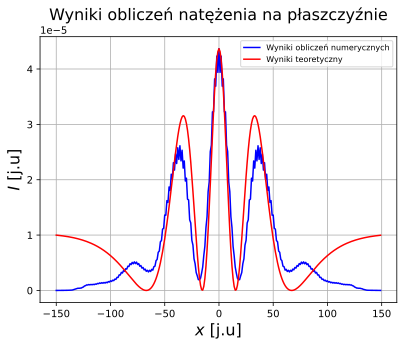

In [5]:
psi_out = output1['h'] - np.ones(grid)
x_pos, y_pos = np.indices(psi_out[0].shape)
offset_ypos = 20
offset_xpos = psi_out.shape[1]//2
x_pos = x_pos - offset_xpos
y_pos = y_pos - offset_ypos

k_wave = omega / np.sqrt(np.max(h_0) * grav)
d = 40
a = 4
y0 = 60
x_plane= x_pos[:,0]
phase_interference = np.cos(0.5 * d * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
phase_diff_envelope = np.sinc(0.5 * a * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
psi_rms = rms_in_xplane(psi_arg=psi_out, x_plane_index=y0+offset_ypos, time_range=slice(80,None))
I_0 = np.max(psi_rms)
psi_theor = I_0 * np.square(phase_diff_envelope * phase_interference)

pyplot.plot(x_plane, psi_rms, color='blue')
pyplot.plot(x_plane, psi_theor, color='red')
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$I$ [j.u]", fontsize=16)
pyplot.legend(["Wyniki obliczeń numerycznych", "Wyniki teoretyczny"], fontsize=8)
pyplot.title("Wyniki obliczeń natężenia na płaszczyźnie", fontsize=16)
pyplot.grid()
pyplot.show()

Na rysunku przedstawie jest wyniki dla płaszczyzny $y_0 = 60$, dla okresu całkowania od 80 kroków do końca symulacji. Jak widać na rysunku, wyniki zgadzają się z ogromną dokładnością w dla środka układu z wynikiem teoretycznym i rozbiegają znacząco na krańcach pudła. Widać również przesunięcie w wyniku numerycznego bliżej krańców pudła. Rozbieżność na krańcach pudła można wytłumaczyć tym, że fala nie doszła do granic pudła oraz tym, że wyniku dyfuzji numerycznej wartość sygnału dalej od środka pudla spada znacząco. Przesunięcie pików ku brzegom pudłą nie wiązałbym z dyfuzją numeryczną, lecz z niedokładnością założeń co do wielkości $a$ oraz $k$ <br>
Na następnym rysunku przedstawiono wartość kwadratu wychylenia $h$ od powierzchni w ostatnim kroku symulacji.

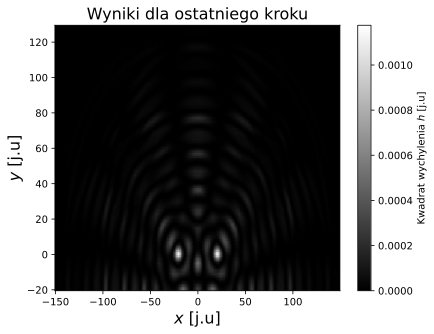

In [6]:
pyplot.pcolormesh(x_pos, y_pos, np.square(psi_out[-1]), cmap="binary_r", rasterized=True, shading="auto")
pyplot.colorbar(label="Kwadrat wychylenia $h$ [j.u]")
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$y$ [j.u]", fontsize=16)
pyplot.title("Wyniki dla ostatniego kroku", fontsize=16)
pyplot.show()

 Na rysunku widać kwadrat wychylenia $h$ od powierzchni. Na rysunku widać, bardzo jasno interferencję, jak również dyfuzję numeryczną.

#### Analiza wyników dla zmniejszenia rozdzielczości czasowej.
Stosunek kroku czasowego $\frac{\Delta t}{\Delta x} = \frac{1}{8}$. <br>
Liczba kroków czasowych $n_t$ = 350. <br>
Zwiększenia rozdzielczości czasowej dla dobranych parametrów symulacji nie jest zauważalne.

In [7]:
grid = (300, 150)
omega = 1.0
h_0 = 1.0
grav = 10

subprocess.run(["python", "solver2.py"])
output_path = os.path.join(os.getcwd(), "output2.npy")
output2 = np.load(output_path, allow_pickle=True).item()

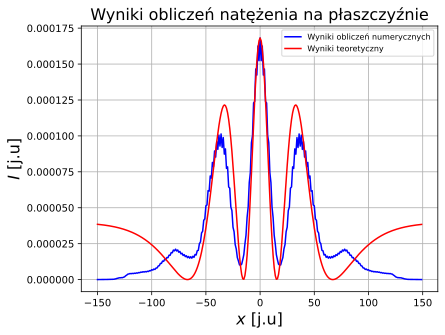

In [8]:
psi_out = output2['h'] - np.ones(grid)
x_pos, y_pos = np.indices(psi_out[0].shape)
offset_ypos = 20
offset_xpos = psi_out.shape[1]//2
x_pos = x_pos - offset_xpos
y_pos = y_pos - offset_ypos

k_wave = omega / np.sqrt(np.max(h_0) * grav)
d = 40
a = 4
y0 = 60
x_plane= x_pos[:,0]
phase_interference = np.cos(0.5 * d * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
phase_diff_envelope = np.sinc(0.5 * a * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
psi_rms = rms_in_xplane(psi_arg=psi_out, x_plane_index=y0+offset_ypos, time_range=slice(160,None))
I_0 = np.max(psi_rms)
psi_theor = I_0 * np.square(phase_diff_envelope * phase_interference)

pyplot.plot(x_plane, psi_rms, color='blue')
pyplot.plot(x_plane, psi_theor, color='red')
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$I$ [j.u]", fontsize=16)
pyplot.legend(["Wyniki obliczeń numerycznych", "Wyniki teoretyczny"], fontsize=8)
pyplot.title("Wyniki obliczeń natężenia na płaszczyźnie", fontsize=16)
pyplot.grid()
pyplot.show()

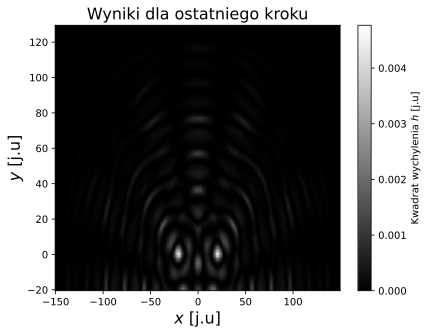

In [9]:
pyplot.pcolormesh(x_pos, y_pos, np.square(psi_out[-1]), cmap="binary_r", rasterized=True, shading="auto")
pyplot.colorbar(label="Kwadrat wychylenia $h$ [j.u]")
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$y$ [j.u]", fontsize=16)
pyplot.title("Wyniki dla ostatniego kroku", fontsize=16)
pyplot.show()

#### Analiza dla dwukrotnie mniejszej siatki.
Rozmiar siatki $n_x = 150, n_y = 75, n_t = 150$ <br>
W wynikach odczytywana płaszczyzna $y_0 = 50$. Jest to związane z tym, że płaszczyzna $y_0 = 60$ jest poza pudłem obliczeniowym. <br>
Z ogólnych porównań od razu widać pogorszenie wyników symulacji. Rozmiar siatki jest najbardziej kluczowym elementem poprawności symulacji. Ze względu na to, że realizacja otwartego warunku brzegowego nie działa wystarczająco dokładnie. Na wynikach przekroju widać odbitą falę oraz natomiast na rysunku przedstawiającym ostatni krok symulacji widać interferencje z falą odbitą od brzegu pudła.

In [10]:
grid = (150, 75)
omega = 1.0
h_0 = 1.0
grav = 10

subprocess.run(["python", "solver3.py"])
output_path = os.path.join(os.getcwd(), "output3.npy")
output3 = np.load(output_path, allow_pickle=True).item()

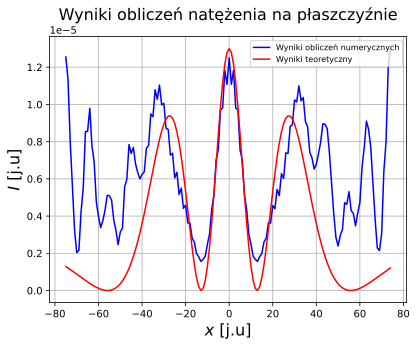

In [11]:
psi_out = output3['h'] - np.ones(grid)
x_pos, y_pos = np.indices(psi_out[0].shape)
offset_ypos = 20
offset_xpos = psi_out.shape[1]//2
x_pos = x_pos - offset_xpos
y_pos = y_pos - offset_ypos

k_wave = omega / np.sqrt(np.max(h_0) * grav)
d = 40
a = 4
y0 = 50
x_plane= x_pos[:,0]
phase_interference = np.cos(0.5 * d * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
phase_diff_envelope = np.sinc(0.5 * a * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
psi_rms = rms_in_xplane(psi_arg=psi_out, x_plane_index=y0+offset_ypos, time_range=slice(80,None))
I_0 = np.max(psi_rms)
psi_theor = I_0 * np.square(phase_diff_envelope * phase_interference)

pyplot.plot(x_plane, psi_rms, color='blue')
pyplot.plot(x_plane, psi_theor, color='red')
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$I$ [j.u]", fontsize=16)
pyplot.legend(["Wyniki obliczeń numerycznych", "Wyniki teoretyczny"], fontsize=8)
pyplot.title("Wyniki obliczeń natężenia na płaszczyźnie", fontsize=16)
pyplot.grid()
pyplot.show()

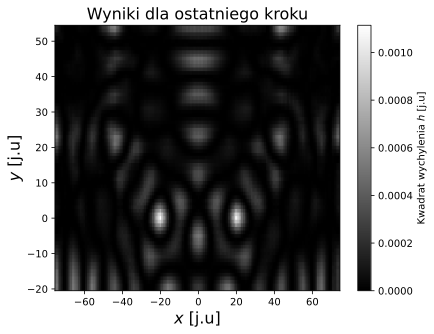

In [12]:
pyplot.pcolormesh(x_pos, y_pos, np.square(psi_out[-1]), cmap="binary_r", rasterized=True, shading="auto")
pyplot.colorbar(label="Kwadrat wychylenia $h$ [j.u]")
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$y$ [j.u]", fontsize=16)
pyplot.title("Wyniki dla ostatniego kroku", fontsize=16)
pyplot.show()

### 4. Wnioski
Interferencja da się w niezwykle dokładny sposób modelować przy użyciu algorytmów całkujących równania płaskiej wody. Większość obecnie występujących problemów można rozwiązać poprzez adekwatnych rozwiązań. Najważniejszym polem do poprawy najprawdopodobniej powinny być otwarte warunki brzegowe. Na moment obecny warunek brzegowy dalej oddaje cześć pędu z powrotem do pódła. Nie tylko zaburza to dokładność wyniku, ale także wprowadza dodatkowe pęd do systemu. To może skutkować złamaniem kryterium CFL. Wyniki możnaby również poprawić redukując w większym stopniu dyfuzję numeryczną albo uwzględniając ją w modelowaniu teoretycznym. Ostatnim problemem są źródła punktowe. Problemem jest ewidentna sztywność dla jądra jedno punktowego. Zwiększanie jądra pozwala na zwalczanie sztywności, ale to wymaga większych siatek. W szczególności mogłoby to być problemem dla symulacji gdzie odległość źródeł $d < \frac{a}{2}$ ponieważ źródła, by zaczęły nachodzić na siebie. Najprawdopodobniej adekwatnym jest też dobranie częstotliwości źródła w taki sposób by wartość $\omega < dt \cdot n_t$